#### %reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai import *
from fastai.vision import *
from torch import nn
from collections import defaultdict
import configparser

# Configure and Filter data

In [2]:
config = configparser.ConfigParser()
config.read('train_2D_oat.ini')

['train_2D_oat.ini']

In [3]:
path = Path(config['data']['dir'])
path.ls()

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/NewLabels'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Images'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Test'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/models'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_big.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_norot_big.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_no_tfms.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/valid.txt')]

In [4]:
#path = Path('/home/suze/seed_images/Data_for_ML_Test/test_model/Oat_test')
#path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train')
#path.ls()

In [5]:
path_img = path/config['data']['images']
path_lbl = path/config['data']['labels']
valid = config['data']['valid']
classes = int(config['data']['classes'])
model_name = config['data']['model']

In [6]:
#path_img = path/'Images' #should later be provided through ini file
#path_lbl = path/'NewLabels' #should later be provided through ini file
#path_img
#path_lbl

In [7]:
img_names=get_image_files(path_img)
img_names[:3]
lbl_names=get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/NewLabels/OB5_zx_0298.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/NewLabels/OB6_x_0106.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/NewLabels/OM1_7_0503.tif')]

In [8]:
def get_mask(img):
    return (path_lbl)/img.name

"""function to filter out images that only contain background; used to calculate appropriate weights; 
function returns the images that also contain seed in a list"""
def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

"""function to filter out images that only contain background; used to filter in the data block API; 
function has to return a boolean"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False
    
def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

def img_train(path_img, valid):
    #create a list of images not in validation set
    path = path_img.parent
    valid_names = loadtxt_str(path/valid)
    img_names = get_image_files(path_img)
    train_img = list(filter(lambda x: (x.name not in valid_names), img_names))
    return train_img

#based of fastai foreground_acc
def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [ ]:
#mask = open_mask(get_mask(img_names[300]))
#mask.data
#count_total=(torch.unique(mask.data, return_counts=True))
#count_total[0].tolist()
#len(img_names)

In [ ]:
#include = filter_background(img_names)
#len(include)
#mask.show()

In [ ]:
#img_list2
img = open_image(img_names[4])
img.show()
#src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [ ]:
train_img = img_train(path_img, valid)

In [ ]:
%time classes_count = count_mask(train_img)
classes_count
#slow for big sets, make faster?
#defaultdict(int, {0: 6594921884, 1: 3243614049, 2: 355819488, 3: 205649589}) #rotation data

Check to make sure all classes are represented in the training set.

In [ ]:
if len(classes_count.items()) != classes: print('Not all classes present in training data.')

In [ ]:
#append class counts in a list 
counts = []
for c in classes_count:
    counts.append(classes_count[c])
counts
#counts = [6594921884, 3243614049, 355819488, 205649589] #rotation data

In [ ]:
weight_ratios =[min(counts)/x for x in counts]
weight_ratios
#weight_ratios = [0.031183021211961332, 0.06340137448331788, 0.5779604432458741, 1.0] #rotation data

# Data Loading

In [9]:
#Configure settings for training
bs = int(config['training_settings']['batch_size'])
wd = float(config['training_settings']['wd'])
lr = float(config['training_settings']['lr'])
size_s = int(config['training_settings']['size_s'])
size_m = int(config['training_settings']['size_m'])
size_l = int(config['training_settings']['size_l'])
epochs_s1 = int(config['training_settings']['epochs_s1'])
epochs_s2 = int(config['training_settings']['epochs_s2'])
epochs_m = int(config['training_settings']['epochs_m'])
epochs_l = int(config['training_settings']['epochs_l'])

In [ ]:
#np.random.seed(42)
src = (SegmentationItemList.from_folder(path)
       .filter_by_folder(include=config['data']['images'])
       .filter_by_func(check_back)
       .split_by_fname_file(valid)
       .label_from_func(get_mask, classes=list(range(classes))))

In [ ]:
#src

In [ ]:
#data = (src.transform(get_transforms(flip_vert=True, 
#                                     max_rotate=90, 
#                                     max_zoom=1.3, 
#                                     xtra_tfms=zoom_crop(scale=(1.,3.), do_rand=True, p=0.1)),
#        tfm_y=True, 
#        size=size_s)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [ ]:
data = (src.transform(
        tfm_y=True, 
        size=size_s)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(4, figsize=(10,7))

# Learning

In [10]:
metrics=acc_seeds

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

Uncomment the block below to find a good learning rate

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
#from fastai.utils.mem import *
#free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
#if free > 8200: bs=8
#else:           bs=8
#print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
#torch.cuda.device_count()
#torch.cuda.is_available()
#torch.cuda.current_device()

In [ ]:
learn.fit_one_cycle(epochs_s1, lr)

In [ ]:
#learn.summary()

In [ ]:
learn.save('stage-small_1')
#learn=None
#gc.collect()

In [ ]:
learn.load('stage-small_1');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(epochs_s2, lrs)

In [ ]:
learn.save('stage-small_2')

In [ ]:
#data_med = (src.transform(get_transforms(flip_vert=True, 
#                                     max_rotate=90, 
#                                     max_zoom=1.3, 
#                                     xtra_tfms=zoom_crop(scale=(1.,3.), do_rand=True, p=0.1)),
#                            tfm_y=True, size=size_m)
#       .databunch(bs=bs)
#       .normalize(imagenet_stats))

In [ ]:
data_med = (src.transform(
        tfm_y=True, 
        size=size_m)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn=None
gc.collect()
learn = unet_learner(data_med, models.resnet34, metrics=metrics, wd=wd)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.load('stage-small_2');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(epochs_m, lrs)

In [ ]:
#learn.show_results()

In [ ]:
learn.save('stage-med')
#learn=None
#gc.collect()

In [ ]:
#data_L = (src.transform(get_transforms(flip_vert=True, 
#                                     max_rotate=90, 
#                                     max_zoom=1.3, 
#                                     xtra_tfms=zoom_crop(scale=(1.,3.), do_rand=True, p=0.1)),
#                                tfm_y=True, size=size_l)
#       .databunch(bs=bs)
#       .normalize(imagenet_stats))

In [ ]:
data_L = (src.transform(
        tfm_y=True, 
        size=size_l)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn=None
gc.collect()
learn = unet_learner(data_L, models.resnet34, metrics=metrics, wd=wd)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.load('stage-med');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(epochs_l, lrs)

In [ ]:
#learn.show_results()

In [ ]:
#get_transforms()[1][0]

In [ ]:
#tfms = (get_transforms(xtra_tfms=crop(size=280)))
#tfms = get_transforms()
#tfms = (get_transforms(xtra_tfms=crop_pad(size=64, padding_mode='border')))
#tfms

In [ ]:
#data_crop = (src.transform(tfms, tfm_y=True, size=256)
#       .databunch(bs=8)
#       .normalize())

In [ ]:
#get_transforms(data_crop)

In [ ]:
#data_crop.show_batch(4, figsize=(10,7))

In [ ]:
learn.export(model_name)

# Training Interpretations on Validation Set

In [ ]:
from fastai.vision.interpret import *
interp = SegmentationInterpretation.from_learner(learn)
#interp = Interpretation.from_learner(learn)
#interp

In [ ]:
top_losses, top_idxs = interp.top_losses(sizes=(size_l,size_l))
top_idxs

In [ ]:
learn.validate(data_L.valid_dl)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
#len(single_img_cm)

In [ ]:
# Look at single worst performing picture
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
def _interp_show_new(self, ims:ImageSegment, classes:Collection=None, sz:int=20, cmap='tab20',
                    title_suffix:str=None):
        "Show ImageSegment with color mapping labels"
        fig,axes=plt.subplots(1,2,figsize=(sz,sz))
        np_im = to_np(ims.data).copy()
        # tab20 - qualitative colormaps support max of 20 distinc colors
        # if len(classes) > 20 close idxs map to same color
        # image
        if classes is not None:
            class_idxs = [self.c2i[c] for c in classes]
            mask = np.max(np.stack([np_im==i for i in class_idxs]),axis=0)
            np_im = (np_im*mask).astype(np.float)
            np_im[np.where(mask==0)] = np.nan
        im=axes[0].imshow(np_im[0], cmap=cmap)

        # labels
        np_im_labels = list(np.unique(np_im[~np.isnan(np_im)]))
        c = len(np_im_labels); n = math.ceil(np.sqrt(c))
        label_im = np.array(np_im_labels + [np.nan]*(n**2-c)).reshape(n,n)
        axes[1].imshow(label_im, cmap=cmap)
        for i,l in enumerate([self.i2c[l] for l in np_im_labels]):
            div,mod=divmod(i,n)
            #l = "\n".join(wrap(l,10)) if len(l) > 10 else l #bug fix
            axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})

        if title_suffix:
            axes[0].set_title(f"{title_suffix}_imsegment")
            axes[1].set_title(f"{title_suffix}_labels")

In [ ]:
import types
def show_xyz_new(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        funcType = types.MethodType
        self._interp_show = funcType(_interp_show_new, self)
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')

In [ ]:
funcType = types.MethodType
interp.show_xyz = funcType(show_xyz_new, interp)
interp.show_xyz(i)

# Evalution of Test Data

In [67]:
from PIL import Image
from fastai.vision.interpret import *

In [68]:
#provide config file name through cmd line
config = configparser.ConfigParser()
config.read('pred_2D_oat.ini')

['pred_2D_oat.ini']

In [69]:
path = Path(config['data']['dir_to_model'])
model = (config['data']['model'])
#raw_img = config['data']['raw_images']
#pred_lbl = config['data']['pred_lbl']

In [70]:
learn = load_learner(path, file=model)
#learn.data.single_ds.tfmargs['size'] = None #ensure match to new image size, 

In [71]:
lsiList = (SegmentationItemList.from_folder(path)
       .split_by_folder(train='Images', valid='Test')
       .label_from_func(get_mask, classes=list(range(classes))))

In [72]:
#data_test = (lsiList.transform(get_transforms(flip_vert=True, 
#                                     max_rotate=90, 
#                                     max_zoom=1.3, 
#                                     xtra_tfms=zoom_crop(scale=(1.,3.), do_rand=True, p=0.1)), 
#        tfm_y=True, 
#        size=300)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [73]:
data_test = (lsiList.transform( 
        tfm_y=True, 
        size=300)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [74]:
learn.data.valid_dl = data_test.valid_dl

In [75]:
data_test

ImageDataBunch;

Train: LabelList (6347 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Valid: LabelList (2503 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Test: None

In [76]:
#In [1]: import torch In [2]: torch.cuda.current_device() Out[2]: 0 In [3]: torch.cuda.device(0) 
import torch
torch.cuda.get_device_name()

'GeForce RTX 2080 Ti'

In [77]:
learn.validate(data_test.valid_dl)

[0.032803953, tensor(0.9462)]

In [78]:
# Interpret
interp = SegmentationInterpretation.from_learner(learn)#,ds_type=DatasetType.Valid)
#interp.plot_confusion_matrix()

In [79]:
#top_losses, top_idxs = interp.top_losses(sizes=(size_l,size_l))
#top_idxs

In [80]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0.0,0.999852
1.0,0.869258
2.0,0.851738
3.0,0.284646


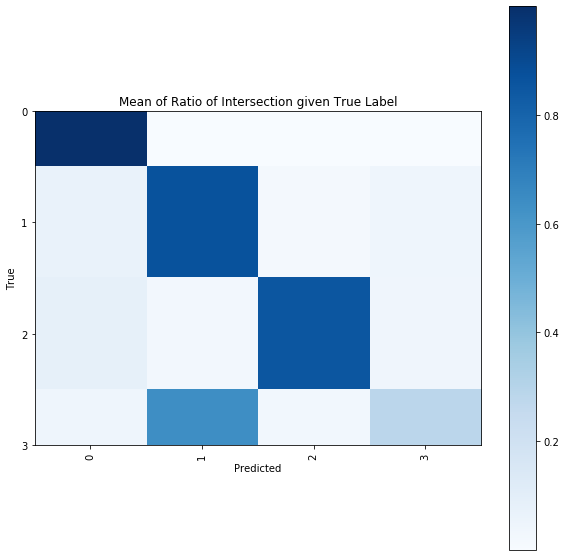

In [81]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")